In [9]:
import random
random.seed(42)

import numpy as np
np.random.seed(42)


data_shape = 256

num_data = 80
batch_size = 8

In [10]:

from PIL import Image
from IPython.display import display
import numpy as np

# origin: buildings with height
# building: buildings without height
# target: the ground truth
# source: the antenna

root_origin = './png/buildingsWHeight/'
root_building = './png/buildings_complete/'
root_target = './gain/'
root_source = './png/antennasWHeight/'

root_pre = './pre/'
root_res = './res/'


def get_origin_data(pic_id, idx):
    img_origin = Image.open(root_origin+str(pic_id)+'.png')
    img_building = Image.open(root_building+str(pic_id)+'.png')
    img_target = Image.open(root_target+str(pic_id)+'_'+str(idx)+'.png')
    img_source = Image.open(root_source+str(pic_id)+'_'+str(idx)+'.png')

    origin_data = np.array(img_origin)
    building_data = np.array(img_building)
    target_data = np.array(img_target)
    source_data = np.array(img_source)

    source = source_data.nonzero()
    source = list(zip(*source))
    source = source[0]

    return origin_data, building_data, target_data, source


In [11]:
import torch
def Load_Data(pic_id, idx):
    data = torch.load(root_pre+str(pic_id)+'_'+str(idx)+'.pt')
    return data

In [12]:
pic_id = 1
data_list = []
for i in range(num_data):
    data = Load_Data(pic_id, i)
    data_list.append(data)

from torch_geometric.data import DataLoader
loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

In [13]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GATConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(42)
        self.input_layer = Linear(data.x.shape[1], hidden_channels)
        self.conv1 = GATConv(hidden_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.conv4 = GATConv(hidden_channels, hidden_channels)
        self.linear = Linear(hidden_channels, 1)


    def forward(self, x, edge_index, edge_attr):

        x = self.input_layer(x)
        
        out = self.conv1(x, edge_index, edge_attr)
        out = F.tanh(out)
        # out = F.dropout(out, training=self.training)

        out = self.conv2(out, edge_index, edge_attr)
        out = F.relu(out)
        # out = F.dropout(out, training=self.training)

        out = self.conv3(out, edge_index, edge_attr)
        out = F.tanh(out)
        # out = F.dropout(out, training=self.training)

        out = self.conv4(out, edge_index, edge_attr)
        out = F.relu(out)
        # out = F.dropout(out, training=self.training)

        out = self.linear(out) * 128

        return out.view(-1)
        # return F.softmax(out, dim=1)
    

In [14]:

model = GNN(hidden_channels=96)

print(model)

device = torch.device('cpu')
print(f'Device: {device}')
data = data.to(device)
model = model.to(device)


# optimizer and criterion

learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = torch.nn.MSELoss()


GNN(
  (input_layer): Linear(in_features=14, out_features=96, bias=True)
  (conv1): GATConv(96, 96, heads=1)
  (conv2): GATConv(96, 96, heads=1)
  (conv3): GATConv(96, 96, heads=1)
  (conv4): GATConv(96, 96, heads=1)
  (linear): Linear(in_features=96, out_features=1, bias=True)
)
Device: cpu


In [15]:
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    out_air = out[data.is_air]
    y_air = data.y[data.is_air]
    loss = torch.sqrt((out_air-y_air)**2+0.1)
    loss = loss.mean()
    # print((out-data.y))
    # loss = torch.sqrt((out-data.y)**2+1)
    # loss = loss.mean()
    # loss = criterion(out[data.is_air], data.y[data.is_air])
    loss.backward()
    optimizer.step()
    return loss


def test(data):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    # pred = out.argmax(dim=1)
    pred = out
    pred = torch.tensor(pred, dtype=torch.int16)
    correct = (pred[data.is_air] == data.y[data.is_air])
    acc = sum(correct) / len(data.y)
    return acc


In [16]:

losses = []
epoches = 10

for epoch in range(epoches):
    for batch_idx, batch in enumerate(loader, 1):
        loss = train(batch)
        losses.append(loss)
        if batch_idx % 1 == 0:
            print(f'Epoch: {epoch:03d}, Batch: {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}')
acc = test(batch)
print(f'Test Accuracy: {acc:.4f}')

Epoch: 000, Batch: 1/10, Loss: nan
Epoch: 000, Batch: 2/10, Loss: nan
Epoch: 000, Batch: 3/10, Loss: nan
Epoch: 000, Batch: 4/10, Loss: nan
Epoch: 000, Batch: 5/10, Loss: nan
Epoch: 000, Batch: 6/10, Loss: nan
Epoch: 000, Batch: 7/10, Loss: nan


KeyboardInterrupt: 

0 ground truth and the result


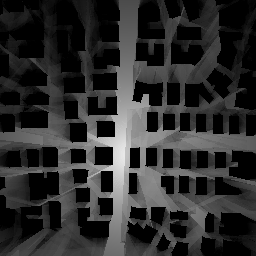

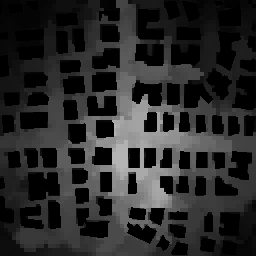

1 ground truth and the result


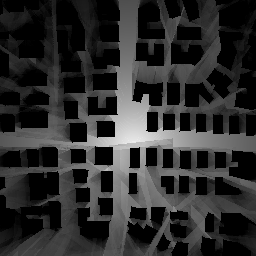

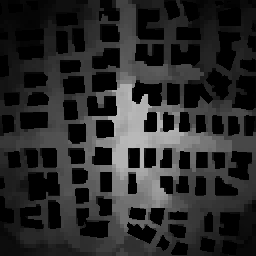

2 ground truth and the result


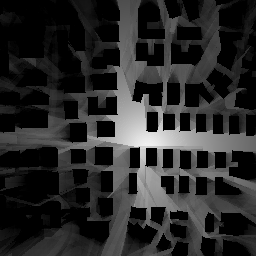

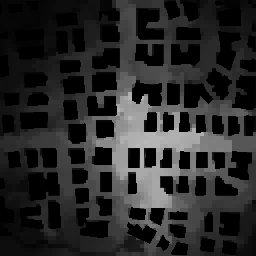

3 ground truth and the result


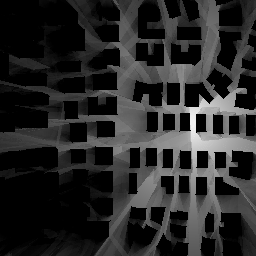

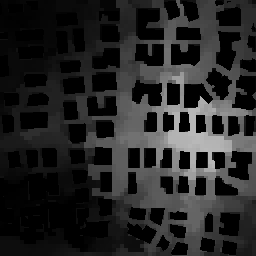

4 ground truth and the result


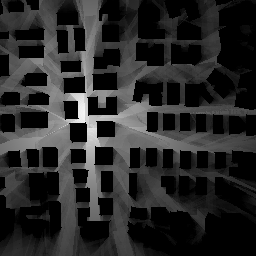

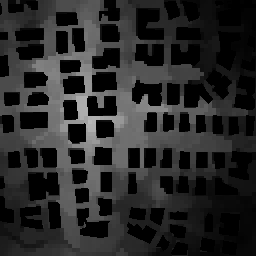

5 ground truth and the result


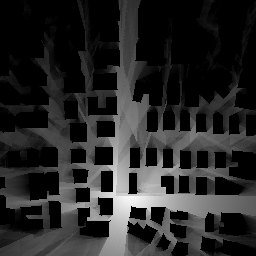

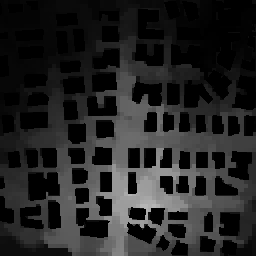

6 ground truth and the result


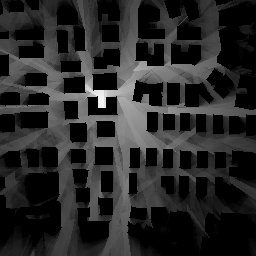

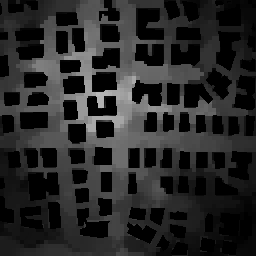

7 ground truth and the result


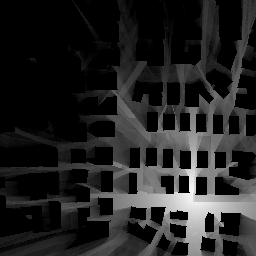

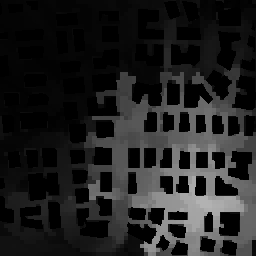

8 ground truth and the result


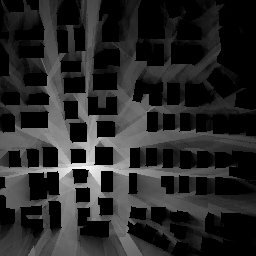

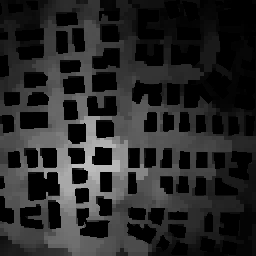

9 ground truth and the result


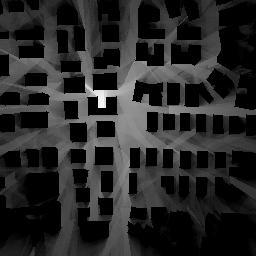

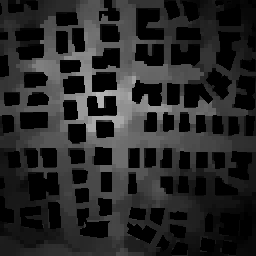

10 ground truth and the result


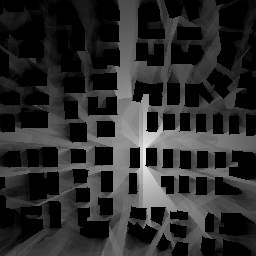

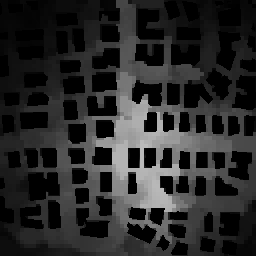

11 ground truth and the result


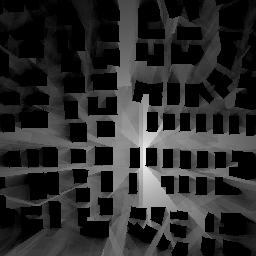

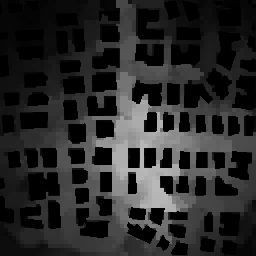

12 ground truth and the result


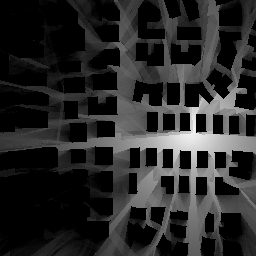

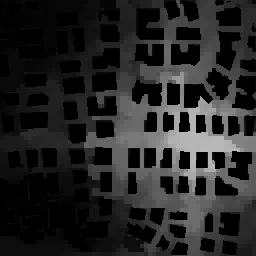

13 ground truth and the result


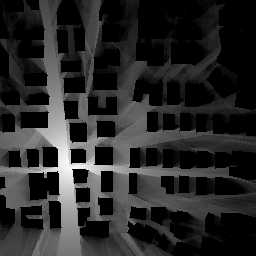

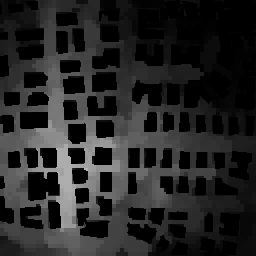

14 ground truth and the result


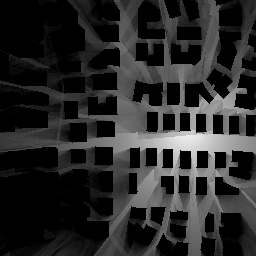

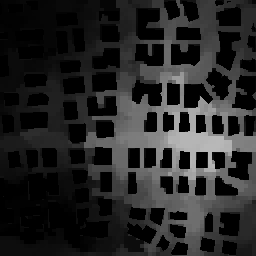

15 ground truth and the result


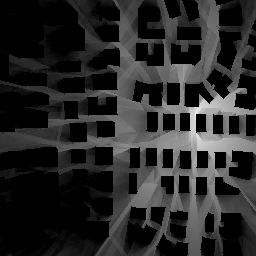

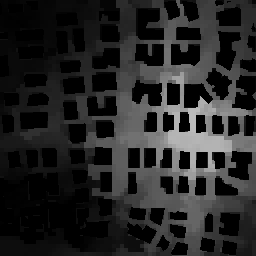

16 ground truth and the result


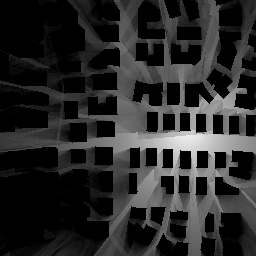

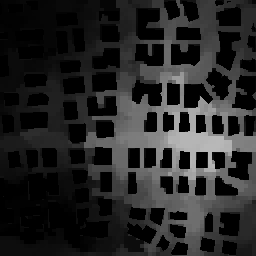

17 ground truth and the result


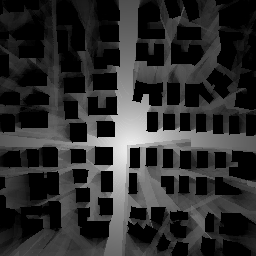

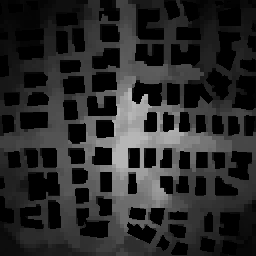

18 ground truth and the result


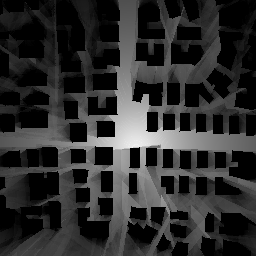

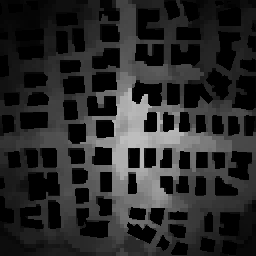

19 ground truth and the result


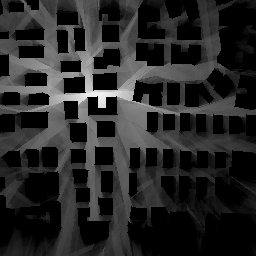

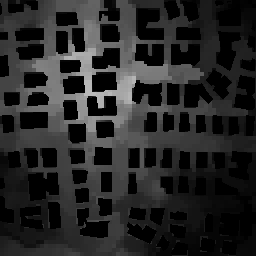

In [ ]:
def show_result(pic_id, idx, save = False):

    data_shape = 256
    _, _, img_target, source = get_origin_data(pic_id, idx)

    data = Load_Data(pic_id, idx)
    out = model(data.x, data.edge_index, data.edge_attr)

    # print(out)
    res = np.int16(out.detach().numpy())
    # print(res)

    img_out = np.zeros([data_shape, data_shape], dtype=np.int16)

    for n in range(data.num_nodes):
        i = int(data.mid[n][0]+source[0])
        j = int(data.mid[n][1]+source[1])
        if data.is_air[n]:
            img_out[i][j] = int(res[n])

    img_out = Image.fromarray(img_out)
    img_out = img_out.convert('L')

    print(idx, 'ground truth and the result')
    display(Image.fromarray(img_target))
    display(img_out)

    if save:
        img_res = Image.new('L', (data_shape*2, data_shape))
        img_res.paste(Image.fromarray(img_target), (0, 0))
        img_res.paste(img_out, (data_shape, 0))
        img_res.save(f'{root_res}res{pic_id}_{idx}.png')


for i in range(20):
    show_result(pic_id, idx=i, save=True)